In [1]:
# Importing necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA,ARMA,ARIMAResults,ARMAResults
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Let's read the data
df = pd.read_csv('accident_UK.csv')
df.head()

,Date,Total_Accident
0,01/01/2014,267
1,02/01/2014,328
2,03/01/2014,308
3,04/01/2014,272
4,05/01/2014,269


In [3]:
# It's a daily data
df.shape

(1461, 2)

In [4]:
# Let's check if there is any missing value
df.isna().sum()

Date              0
Total_Accident    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            1461 non-null   object
 1   Total_Accident  1461 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


In [6]:
# The data is until 2017 December
df.tail()

,Date,Total_Accident
1456,27/12/2017,264
1457,28/12/2017,296
1458,29/12/2017,240
1459,30/12/2017,210
1460,31/12/2017,188


In [7]:
# Let's make the Date column to pandas date time object
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.head()

,Date,Total_Accident
0,2014-01-01,267
1,2014-02-01,328
2,2014-03-01,308
3,2014-04-01,272
4,2014-05-01,269


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1461 non-null   datetime64[ns]
 1   Total_Accident  1461 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 23.0 KB


In [10]:
df = df.sort_values(by = 'Date')
df.head()

,Date,Total_Accident
0,2014-01-01,267
31,2014-01-02,409
59,2014-01-03,392
90,2014-01-04,432
120,2014-01-05,434


In [11]:
df = df.set_index('Date')

In [12]:
df.head()

,Total_Accident
Date,
2014-01-01,267
2014-01-02,409
2014-01-03,392
2014-01-04,432
2014-01-05,434


In [13]:
# Let's make the daily data to monthly data
y = df['Total_Accident'].resample('MS').mean()

In [14]:
df = pd.DataFrame(y)

In [15]:
df.head()

,Total_Accident
Date,
2014-01-01,413.870968
2014-02-01,376.607143
2014-03-01,390.193548
2014-04-01,386.166667
2014-05-01,398.967742


<AxesSubplot:xlabel='Date'>

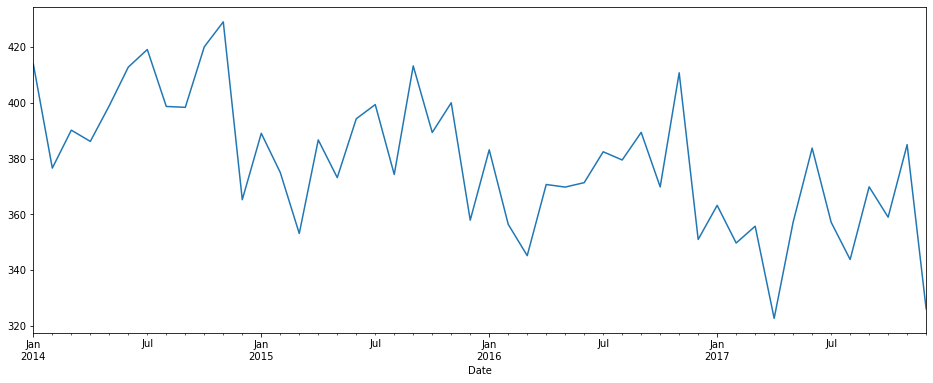

In [16]:
# Let's plot out the Total_Accident column
df['Total_Accident'].plot(figsize=(16,6))

In [17]:
# Augmented dickey fuller test for checking the stationarity 

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [18]:
adf_test(df['Total_Accident'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.236722
p-value                  0.193188
# lags used              1.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
result = seasonal_decompose(df['Total_Accident'])

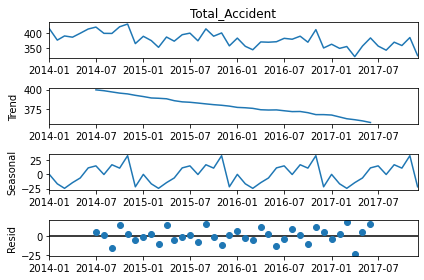

In [20]:
result.plot();

<AxesSubplot:xlabel='Date'>

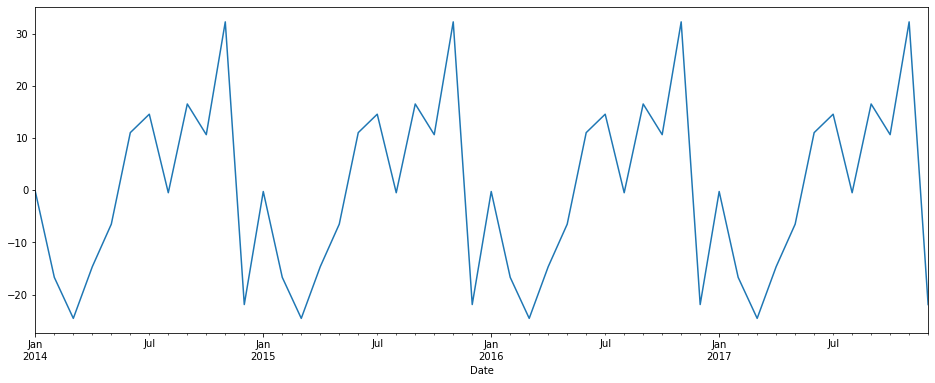

In [21]:
result.seasonal.plot(figsize=(16,6))

In [22]:
# Seasonality is present in the data which can't be ignored
# Let's find out the order of our SARIMA model
# As there is no exogenous variable, we will use simple SARIMA model
auto_arima(df['Total_Accident'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -190.327
Date:                              Tue, 06 Apr 2021   AIC                            392.654
Time:                                      16:13:04   BIC                            403.755
Sample:                                           0   HQIC                           396.831
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0098      0.115     -0.086      0.932      -0.234       0.215
ma.L1         -1.2370      0.136     -9.088      0.000      -1.504      -0.970
ma.L2          0.2509      0.173      1.452      0.146      -0.088       0.590
ar.S.L12       0.9917      0.097     10.261      0.000       0.802       1.181
ma.S.L12      -0.7791      1.203     -0.648      0.517      -3.137       1.579
sigma2       109.7953    113.182      0.970      0.332    -112.036     331.627
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.86   Prob(JB):                         0.92
Heteroskedasticity (H):               1.18   Skew:                             0.11
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
len(df)

48

In [24]:
# Let's split the data into training and testing set
# 36 months for training and 12 months for testing
train = df.iloc[:36]
test = df.iloc[36:]

In [25]:
# Make the model with generated order from auto arima
model = SARIMAX(train['Total_Accident'],order=(0,1,2),seasonal_order=(1,0,1,12))

In [26]:
# Fit the model
results = model.fit()

In [27]:
# Predict the number of road accident on testing data
start = len(train)
end = len(train)+len(test)-1
prediction = results.predict(start,end,typ = 'levels').rename('Prediction of test data')

<AxesSubplot:xlabel='Date'>

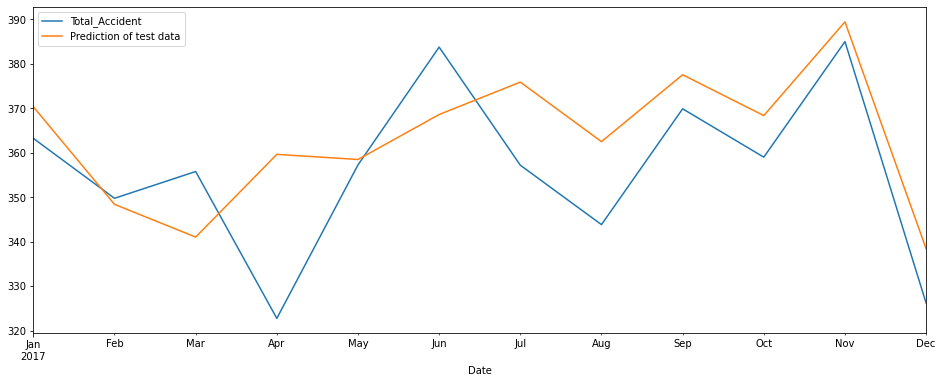

In [28]:
# Let's see how our prediction looks like
test['Total_Accident'].plot(figsize=(16,6),legend=True)
prediction.plot(legend=True)

In [29]:
# Let's see what is the decision metrics
# MSE
# RMSE
from sklearn.metrics import mean_squared_error

In [30]:
mean_squared_error(test['Total_Accident'],prediction)

239.21014887828844

In [31]:
np.sqrt(mean_squared_error(test['Total_Accident'],prediction))

15.466420040794457

In [32]:
test['Total_Accident'].mean()

356.16350486431134

## Forecast into unknown future

In [33]:
# In this case we will use the entire dataset for training purpose
# Because we donot want to lose any information during forecast
# We will use 2018 year (12 months) for forecasting as our length of testing dataset was 12
# Rule of thumb -----> len(test)=len(forecast)
model = SARIMAX(df['Total_Accident'],order=(0,1,2),seasonal_order=(1,0,1,12))
result = model.fit()

In [34]:
start = len(df)
end = len(df)+11
predictions = result.predict(start,end,typ='levels').rename('Forecasted Accident in the year 2018')

<AxesSubplot:xlabel='Date'>

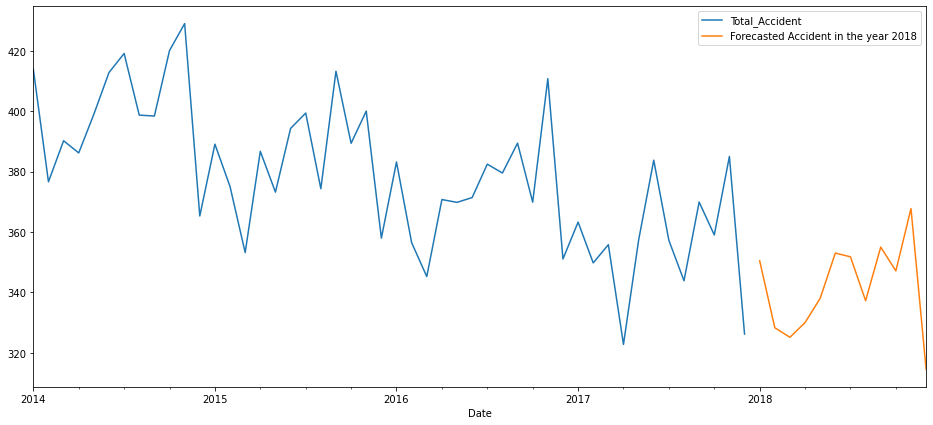

In [35]:
df['Total_Accident'].plot(figsize=(16,7),legend = True)
predictions.plot(legend=True)

## Thanks for viewing my repo.